## Import Libraries

In [1]:
import os
    
# Main libraries that we will use in this kernel
import datetime
import numpy as np
import pandas as pd

# # garbage collector: free some memory is needed
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


import time

from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.path.abspath(os.getcwd())
PATH = "/content/drive/MyDrive/Master Data Science/Capstone NDS/Dataset/"
os.chdir(PATH)

In [3]:
import pickle5 as pickle
data = pickle.load( open( "df_pickle", "rb" ))

## Functions

In [4]:
#10 € por cada cuenta vendida, 40€ por productos de ahorro e inversión (planes, fondos, etc) y 60 por finnanciación (prestamos y tarjetas)

v_10 = ['em_acount_diff', 'emc_account_diff', 'payroll_account_diff','em_account_p_diff']
v_40 = ['funds_diff', 'pension_plan_diff', 'short_term_deposit_diff', 'long_term_deposit_diff', 'securities_diff']
v_60 = ['loans_diff', 'mortgage_diff', 'debit_card_diff', 'credit_card_diff']

def calc_revenue(df):
  for column in df.columns:
    if 'diff' in column:
      if column in v_10:
        df['revenue_'+column] = 10*df[df[column]==1][column]
        df = df.drop(columns=column,axis=1)
      elif column in v_60:
        df['revenue_'+column] = 60*df[df[column]==1][column]
        df = df.drop(columns=column, axis=1)
      else:
        df['revenue_'+column] = 40*df[df[column]==1][column]
        df = df.drop(columns=column, axis=1)
  return df

In [5]:
def alta_baja(df,new_df):
    for column in df.columns:
        if 'diff' in column:
            new_df[column[:-5]] = df[column[:-5]]
            new_df['baja_'+column] = df[df[column]==-1][column]
            new_df['alta_'+column] = df[df[column]==1][column]
            new_df['total_'+column] = df[column]
    return new_df

In [6]:
def revenue_productos(df,new_df):
    for column in df.columns:
        if 'diff' in column:
            new_df[column] = df[column]
    return new_df

In [7]:
class Plots(object):
    
    def __init__(self, df, products=[]):
        
        self.df = df
        self.products = products

    def alta_baja_plot(self): #Función para plotear altas y bajas por producto
        # resample the data on a monthly basis
        sns.set(style="darkgrid")
        
        #Dataframe para plotear el total de bajas y altas para el grupo entero de productos introducido
        x_sum_altas = self.df.groupby(["pk_partition"])[['alta_'+product+'_diff' for product in self.products]].sum()
        x_sum_bajas = self.df.groupby(["pk_partition"])[['baja_'+product+'_diff' for product in self.products]].sum()
        
        x_sum_altas = x_sum_altas.sum(axis=1)
        x_sum_bajas = x_sum_bajas.sum(axis=1)
        
        x_sum_altas.index = x_sum_altas.index.strftime('%B %Y')
        x_sum_bajas.index = x_sum_bajas.index.strftime('%B %Y')
        
        #Plot de altas y bajas para cada producto
        for product in self.products:
            x = self.df[["pk_partition",product,'baja_'+product+'_diff','alta_'+product+'_diff',
                              'total_'+product+'_diff']].set_index("pk_partition").resample("M").sum()
            fig, ax =plt.subplots(1,2,figsize = (18, 7))
            x.index = x.index.strftime('%B %Y')

            bar1 = sns.barplot(x=x.index,y=x['baja_'+ product +'_diff'],color='darkblue',ax=ax[0])
            bar2 = sns.barplot(x=x.index, y=x['alta_'+ product +'_diff'], estimator=sum, ci=None,  color='lightblue',ax=ax[0])
            line1 = sns.lineplot(data = x['total_'+ product+'_diff'], marker='o', sort = False, color = 'lightcoral',ax=ax[0])
            line2 = sns.lineplot(data = x[product],marker='o',sort = False, color = 'coral',ax=ax[1])
            
            top_bar = mpatches.Patch(color='darkblue', label='Withdraw')
            bottom_bar = mpatches.Patch(color='lightblue', label='Subscription')
            balance_line = mpatches.Patch(color = 'lightcoral',label = 'Balance')
            total_line = mpatches.Patch(color = 'coral',label = 'Total')

            ax[0].legend(handles=[top_bar, bottom_bar,balance_line])
            ax[0].tick_params(labelrotation=45)
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(product)
            ax[0].title.set_text("Monthly subscriptions")

            ax[1].legend(handles=[total_line])
            ax[1].tick_params(labelrotation=45)
            ax[1].set_xlabel('Time')
            ax[1].set_ylabel(product)
            ax[1].title.set_text("Total active subscriptors")

            plt.show()
            
        #Plot del total de bajas y altas del grupo entero de productos.    
        plt.figure(figsize = (18, 7)) 
        bar_sum_altas = sns.barplot(x=x_sum_altas.index,y=x_sum_altas.values,color='lightblue')
        bar_sum_bajas = sns.barplot(x=x_sum_bajas.index,y=x_sum_bajas.values,color='darkblue')
        
        sum_bar = mpatches.Patch(color = 'lightblue',label = 'Subscription')
        sum_bar_bajas = mpatches.Patch(color = 'darkblue',label = 'Withdraw')
        
        plt.title("Monthly registration for the entire group")
        plt.legend(handles = [sum_bar,sum_bar_bajas])
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.show()
        
    def alta_baja_total(self): #función para plotear altas y bajas totales de todos los productos de la empresa

        x_total_alta = self.df.groupby(["pk_partition"])[[column for column in self.df.columns if 'alta' in column]].sum()
        x_total_baja = self.df.groupby(["pk_partition"])[[column for column in self.df.columns if 'baja' in column]].sum() 

        x_total_alta = x_total_alta.sum(axis=1)
        x_total_baja = x_total_baja.sum(axis=1)
        
        x_total_alta.index = x_total_alta.index.strftime('%B %Y')
        x_total_baja.index = x_total_baja.index.strftime('%B %Y') 
        
        plt.figure(figsize = (18, 7)) 
        
        altas = sns.barplot(x=x_total_alta.index,y=x_total_alta.values,color='lightblue')
        bajas = sns.barplot(x=x_total_baja.index,y=x_total_baja.values,color='darkblue')
        
        sum_bar = mpatches.Patch(color = 'lightblue',label = 'Subscription')
        sum_bar_bajas = mpatches.Patch(color = 'darkblue',label = 'Withdraw')
        
        plt.title("Monthly registration for all portfolio")
        plt.legend(handles = [sum_bar,sum_bar_bajas])
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.show()
        
    def revenue_plot(self):

        for index in range(len(self.products)):
            self.products[index] = 'revenue_'+self.products[index]+'_diff'
        # resample the data on a monthly basis

        x = self.df[["pk_partition"]+self.products].set_index("pk_partition").resample("M").sum()
        x.index = x.index.strftime('%B %Y')

        x = x.reset_index()
        x_melted = x.melt(id_vars='pk_partition')

        plt.figure(figsize = (18, 7))
        sns.barplot(x='pk_partition', y='value', hue='variable', data=x_melted)
        plt.title("Monthly sales")
        plt.xticks(rotation=45)
        plt.legend();

        
    def total_revenue_plot(self):

        
        x_total_revenue = self.df.groupby(["pk_partition"])[[column for column in self.df.columns if 'revenue' in column]].sum()

        x_total_revenue = x_total_revenue.sum(axis=1)
        
        x_total_revenue.index = x_total_revenue.index.strftime('%B %Y')

        plt.figure(figsize = (18, 7)) 
        sns.barplot(x=x_total_revenue.index,y=x_total_revenue.values,color='darkblue')
        
        sum_bar = mpatches.Patch(color = 'darkblue',label = 'Total revenue')

        
        plt.title("Monthly revenue for all portfolio")
        plt.legend(handles = [sum_bar])
        plt.xticks(rotation=45)
        plt.xlabel('Time')
        plt.show()

### DF merged

#### Productos por género

In [8]:
# crear un df con solo una patición para que no pete colab
df2 = data[data['pk_partition'] == '2019-05-28']

In [9]:
#con dos particiones
df3 = data[(data['pk_partition'] == '2019-05-28') | (data['pk_partition'] == '2019-04-28')]

In [10]:
# para que no haya -1 y así con los groupby o pivot table se pueda sumar directamente
df2 = df2.replace(-1, 0)

In [11]:
df3 = df3.replace(-1, 0)

In [12]:
df3.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
5134317,16063,2019-04-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2019,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5523397,16063,2019-05-28,2018-11-19,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2019,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5134321,16203,2019-04-28,2018-12-23,KAT,1.0,01 - TOP,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,ES,8.0,V,70,N,NaN,0,2019,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5523396,16203,2019-05-28,2018-12-23,KAT,1.0,01 - TOP,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,ES,8.0,V,70,N,NaN,0,2019,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5134320,16502,2019-04-28,2018-09-30,KHN,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0,0,1,ES,28.0,H,58,N,NaN,0,2019,4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_pivot = pd.pivot_table(data[data['debit_card_diff'] == 1], index='pk_partition', columns='gender', values='pk_cid', aggfunc='count')
df_pivot.head()

gender,H,V
pk_partition,,
2018-02-28,1529,2088
2018-03-28,1689,2252
2018-04-28,1403,2004
2018-05-28,1316,1794
2018-06-28,1407,2207


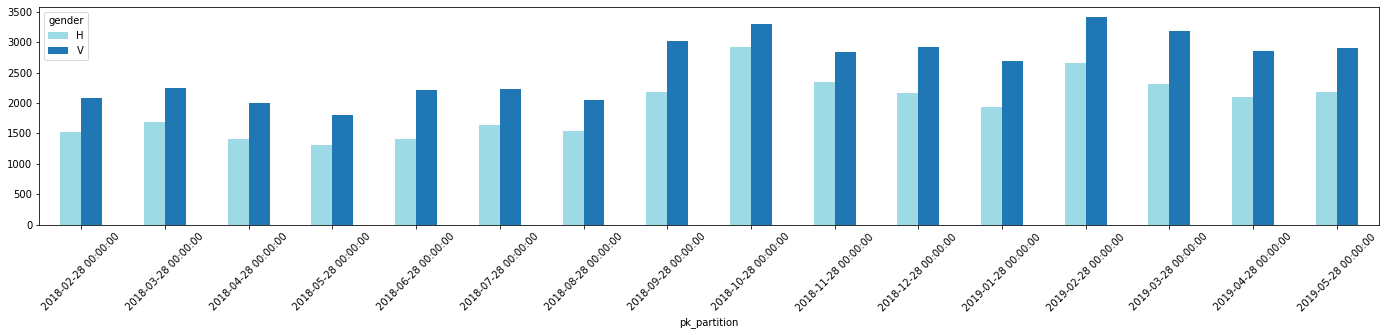

In [14]:
df_pivot.plot.bar(stacked=False, figsize = [24,4], colormap='tab20_r')
plt.xticks(rotation=45)
plt.verbose = False

In [15]:
productos = ['loans_diff', 'mortgage_diff', 'funds_diff', 'securities_diff','long_term_deposit_diff', 'credit_card_diff', 'pension_plan_diff', 'payroll_account_diff',
       'emc_account_diff', 'debit_card_diff', 'em_account_p_diff', 'em_acount_diff']

In [16]:
part_gen = df2.groupby(['gender']).sum()[productos].T
part_gen

gender,H,V
loans_diff,0.0,0.0
mortgage_diff,0.0,0.0
funds_diff,9.0,9.0
securities_diff,12.0,27.0
long_term_deposit_diff,7.0,5.0
credit_card_diff,292.0,466.0
pension_plan_diff,1350.0,1441.0
payroll_account_diff,689.0,822.0
emc_account_diff,616.0,977.0
debit_card_diff,2179.0,2906.0


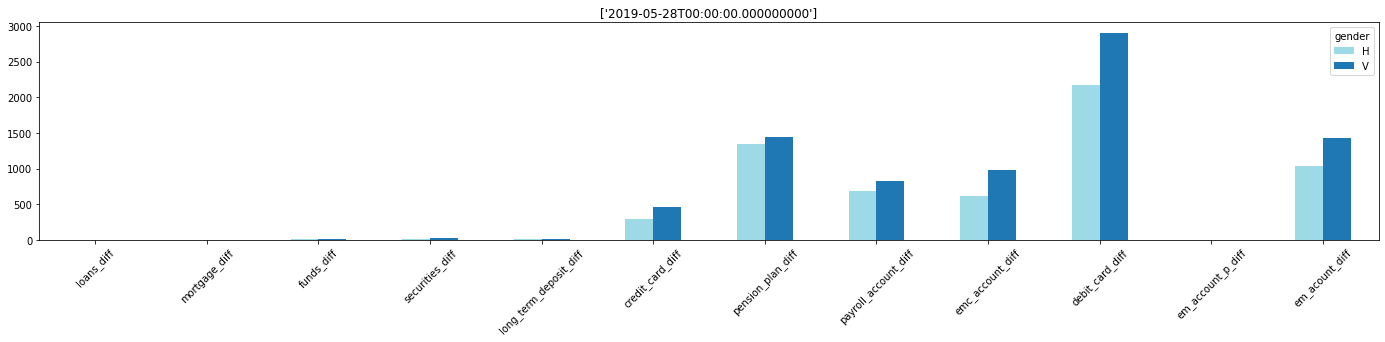

In [17]:
part_gen.plot.bar(stacked=False, figsize = [24,4], colormap='tab20_r')
plt.xticks(rotation=45)
plt.title(df2['pk_partition'].unique())
plt.verbose = False

#### Edad y género por Productos

In [18]:
for index, pr in enumerate(productos):
  print(index, pr)

0 loans_diff
1 mortgage_diff
2 funds_diff
3 securities_diff
4 long_term_deposit_diff
5 credit_card_diff
6 pension_plan_diff
7 payroll_account_diff
8 emc_account_diff
9 debit_card_diff
10 em_account_p_diff
11 em_acount_diff


In [19]:
part_age_pivot = pd.pivot_table(df2[df2['funds_diff'] == 1] , index= ['funds_diff', 'gender'], values='age', aggfunc='mean')
part_age_pivot

age
funds_diff gender           
1.0        H       50.555556
           V       55.000000

In [20]:
part_age_pivot_2 = pd.pivot_table(df2[df2['credit_card_diff'] == 1] , index= ['credit_card_diff', 'gender'], values='age', aggfunc='mean')
part_age_pivot_2

age
credit_card_diff gender           
1.0              H       41.931507
                 V       41.879828

In [21]:
pd.merge(part_age_pivot, part_age_pivot_2, 'left', on =['gender'], suffixes=['_dif_debit_card', '_dif_credit_card'] )

,age_dif_debit_card,age_dif_credit_card
gender,,
H,50.555556,41.931507
V,55.000000,41.879828


In [22]:
def Pivot_Prod_Age(df, prod):
  return(pd.pivot_table(df[df[prod] == 1] , index= [prod, 'gender'], values='age', aggfunc='mean'))

In [23]:
pt= pd.DataFrame()
age_merged= pd.DataFrame()
for index, prod in enumerate(productos):
  if df2[prod].sum() != 0:
    pt = Pivot_Prod_Age(df2, prod)
    if age_merged.empty:
      age_merged = pt
      age_merged.columns = ['age_%s'%prod]
    else:
      pt.columns = ['age_%s'%prod]
      age_merged = pd.merge(age_merged, pt, 'left', on =['gender'])

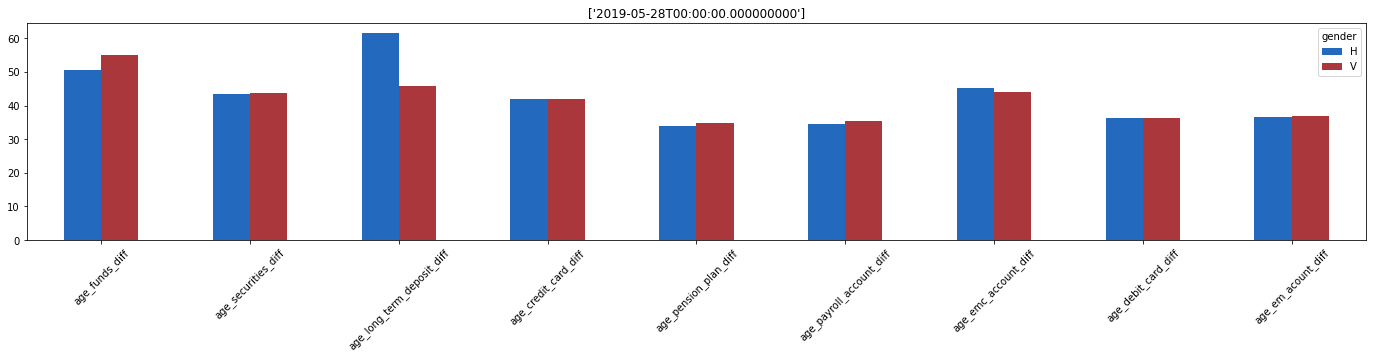

In [24]:
age_merged.T.plot.bar(stacked=False, figsize = [24,4], colormap='vlag')
plt.xticks(rotation=45)
plt.title(df2['pk_partition'].unique())
plt.verbose = False

#### si nuevos productos los contratan los clientes nuevos o previos

In [25]:
data.head().sort_values(by= 'pk_cid')

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
1479563,15891,2018-07-28,2018-07-28,KAT,1.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,ES,28.0,H,59,N,NaN,0,2018,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168122,15891,2018-08-28,2018-07-28,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,59,N,NaN,0,2018,8,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2962973,16063,2018-11-28,2018-11-19,KAT,1.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2018,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3628236,16063,2018-12-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2018,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4028169,16063,2019-01-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data[data['pk_cid'] == 1050613]

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,22,N,119775.54,0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472596,1050613,2018-02-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,22,N,119775.54,0,2018,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693180,1050613,2018-03-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,22,N,119775.54,0,2018,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1581538,1050613,2018-07-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,22,N,119775.54,0,2018,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2050117,1050613,2018-08-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,22,N,119775.54,0,2018,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2331062,1050613,2018-09-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,23,N,119775.54,0,2018,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2673594,1050613,2018-10-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,23,N,119775.54,0,2018,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3335098,1050613,2018-11-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,23,N,119775.54,0,2018,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3416910,1050613,2018-12-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,23,N,119775.54,0,2018,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4162354,1050613,2019-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,50.0,H,23,N,119775.54,0,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,

## Altas y Bajas

In [27]:
alta_baja_df = pd.DataFrame()
alta_baja_df[['pk_cid', 'pk_partition']] = data[['pk_cid', 'pk_partition']]
alta_baja_df= alta_baja(data,alta_baja_df)

In [28]:
alta_baja_df.head()

,pk_cid,pk_partition,em_account_p,baja_em_account_p_diff,alta_em_account_p_diff,total_em_account_p_diff,em_acount,baja_em_acount_diff,alta_em_acount_diff,total_em_acount_diff,emc_account,baja_emc_account_diff,alta_emc_account_diff,total_emc_account_diff,short_term_deposit,baja_short_term_deposit_diff,alta_short_term_deposit_diff,total_short_term_deposit_diff,funds,baja_funds_diff,alta_funds_diff,total_funds_diff,loans,baja_loans_diff,alta_loans_diff,total_loans_diff,mortgage,baja_mortgage_diff,alta_mortgage_diff,total_mortgage_diff,pension_plan,baja_pension_plan_diff,alta_pension_plan_diff,total_pension_plan_diff,payroll_account,baja_payroll_account_diff,alta_payroll_account_diff,total_payroll_account_diff,long_term_deposit,baja_long_term_deposit_diff,alta_long_term_deposit_diff,total_long_term_deposit_diff,debit_card,baja_debit_card_diff,alta_debit_card_diff,total_debit_card_diff,credit_card,baja_credit_card_diff,alta_credit_card_diff,total_credit_card_diff,securities,baja_securities_diff,alta_securities_diff,total_securities_diff
1479563,15891,2018-07-28,0,NaN,NaN,NaN,1,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
2168122,15891,2018-08-28,0,NaN,NaN,0.0,0,-1.0,NaN,-1.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0
2962973,16063,2018-11-28,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
3628236,16063,2018-12-28,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0
4028169,16063,2019-01-28,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0


In [29]:
alta_baja_df.columns

Index(['pk_cid', 'pk_partition', 'em_account_p', 'baja_em_account_p_diff',
       'alta_em_account_p_diff', 'total_em_account_p_diff', 'em_acount',
       'baja_em_acount_diff', 'alta_em_acount_diff', 'total_em_acount_diff',
       'emc_account', 'baja_emc_account_diff', 'alta_emc_account_diff',
       'total_emc_account_diff', 'short_term_deposit',
       'baja_short_term_deposit_diff', 'alta_short_term_deposit_diff',
       'total_short_term_deposit_diff', 'funds', 'baja_funds_diff',
       'alta_funds_diff', 'total_funds_diff', 'loans', 'baja_loans_diff',
       'alta_loans_diff', 'total_loans_diff', 'mortgage', 'baja_mortgage_diff',
       'alta_mortgage_diff', 'total_mortgage_diff', 'pension_plan',
       'baja_pension_plan_diff', 'alta_pension_plan_diff',
       'total_pension_plan_diff', 'payroll_account',
       'baja_payroll_account_diff', 'alta_payroll_account_diff',
       'total_payroll_account_diff', 'long_term_deposit',
       'baja_long_term_deposit_diff', 'alta_long_ter

### Altas y Bajas total portfolio

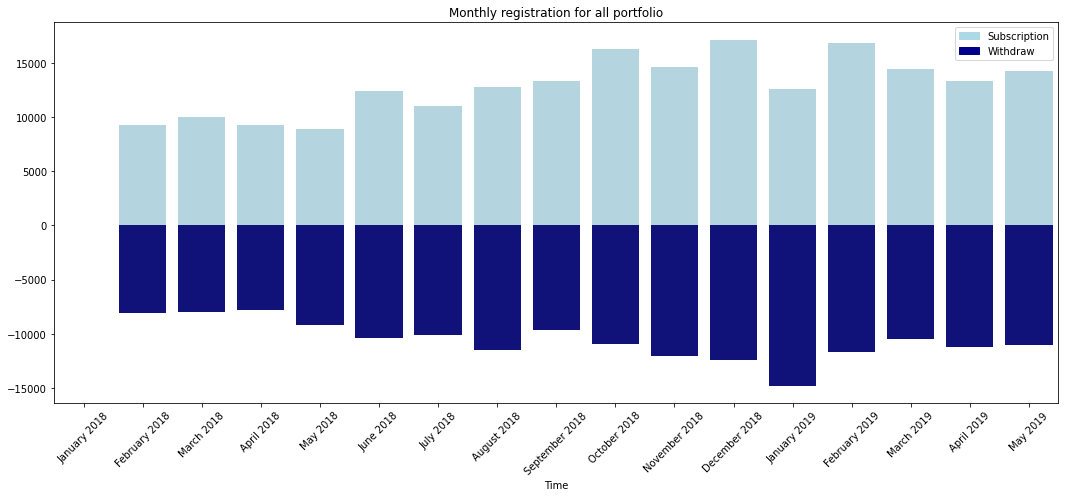

In [30]:
plot_class = Plots(df=alta_baja_df)

plot_class.alta_baja_total()


### Altas y Bajas por grupo producto

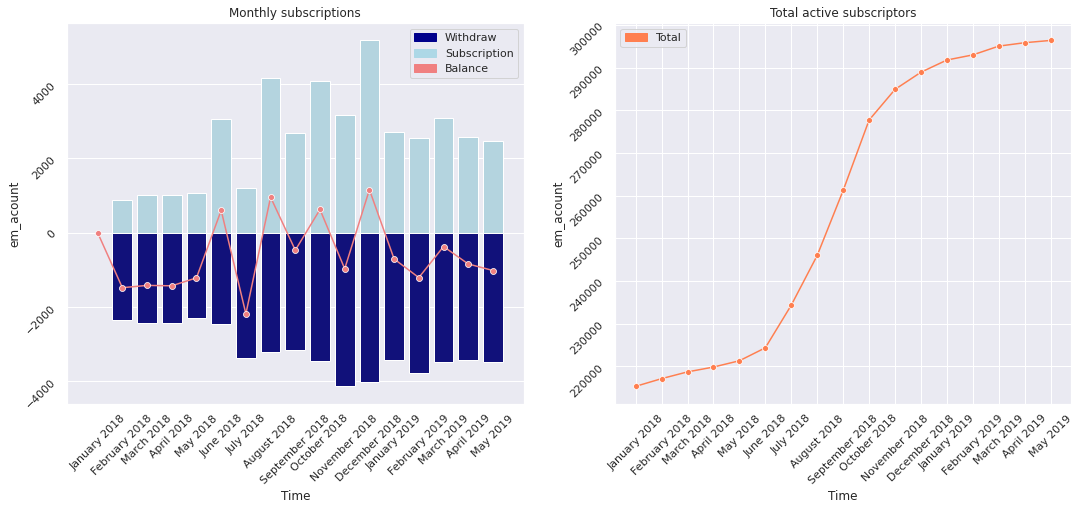

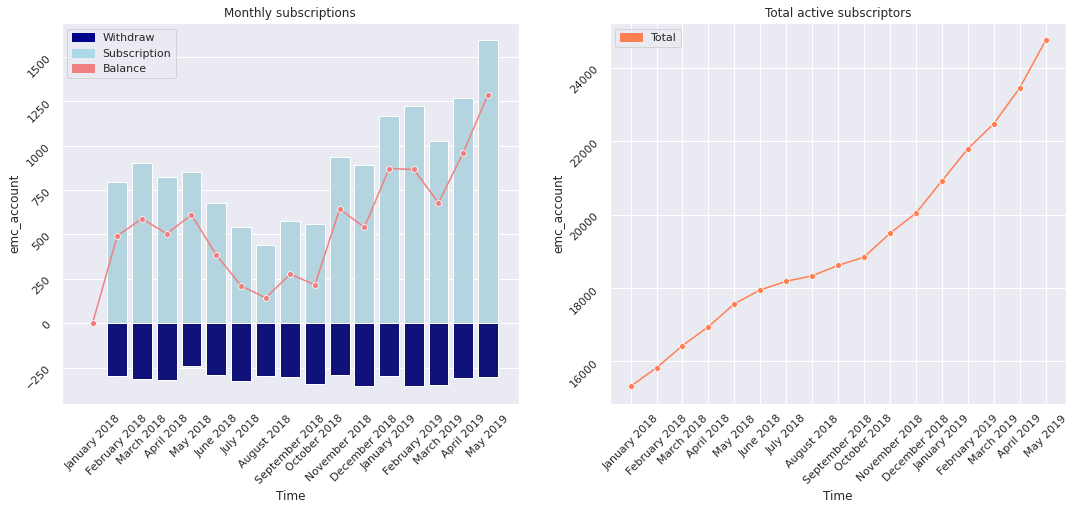

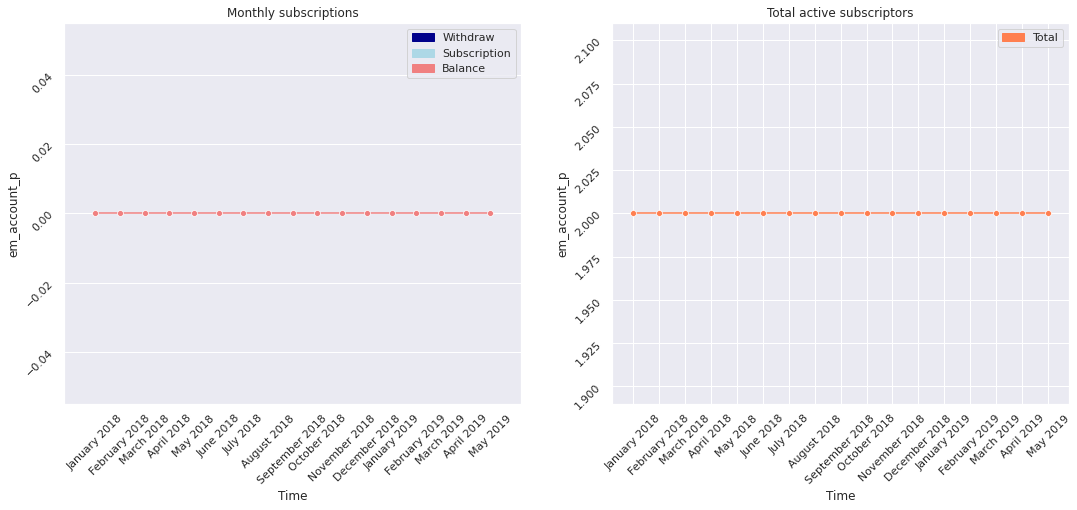

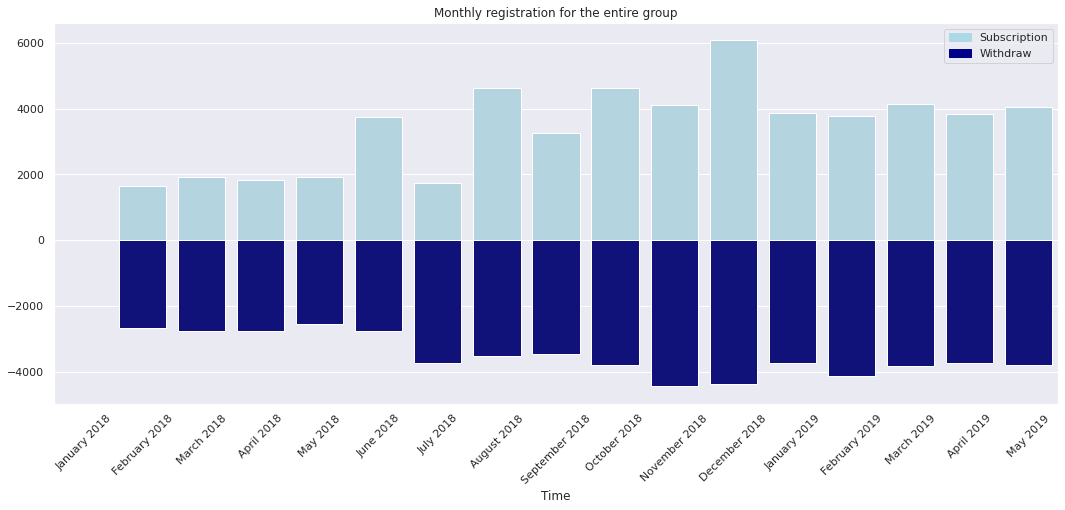

In [31]:
v_10 = ['em_acount', 'emc_account' ,'em_account_p'] #'payroll_account'

plot_class = Plots(df=alta_baja_df,products=v_10)

plot_class.alta_baja_plot()
    

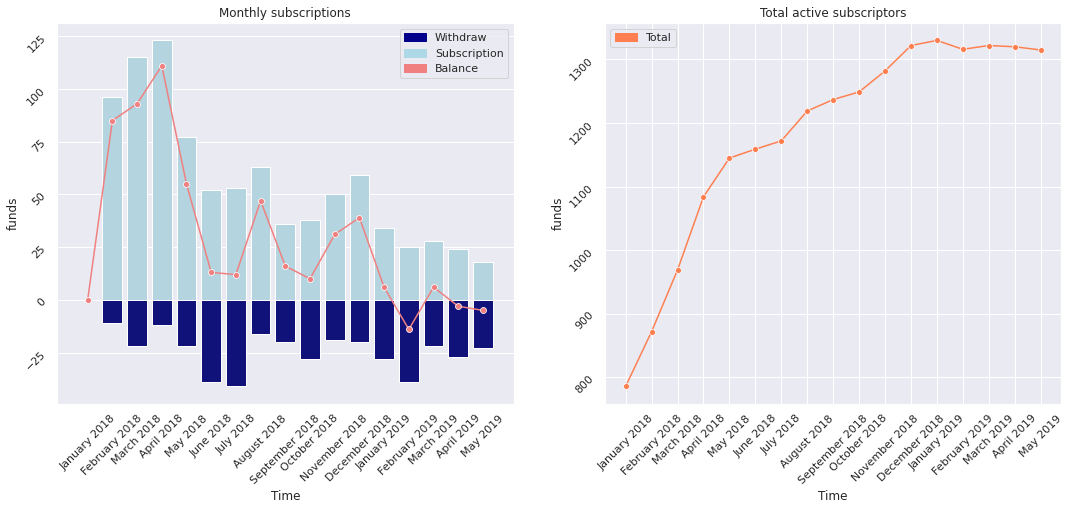

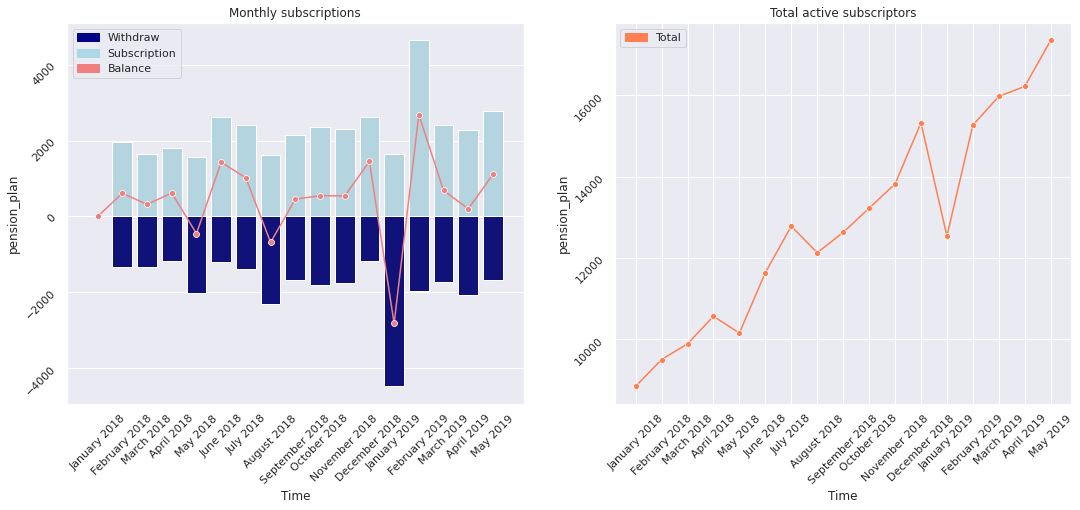

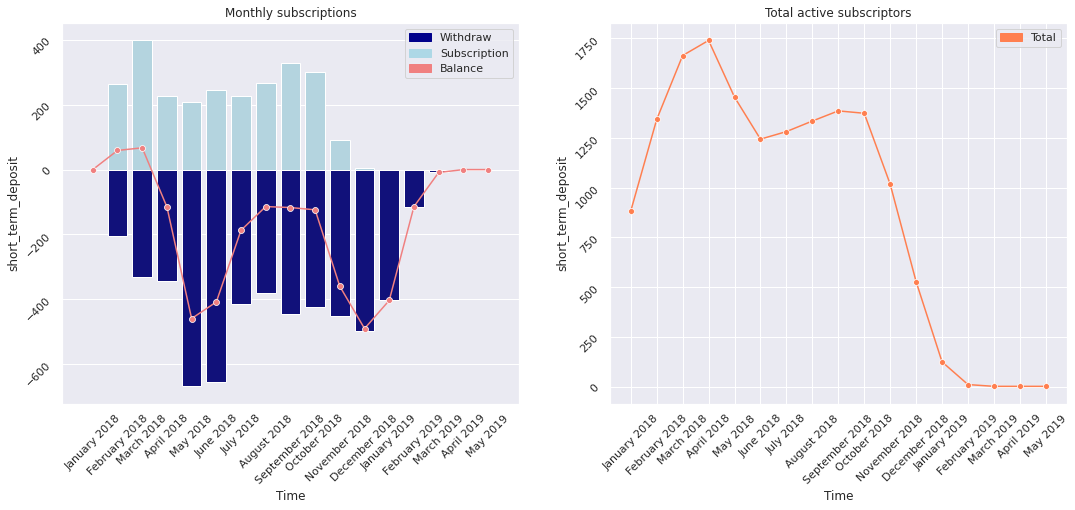

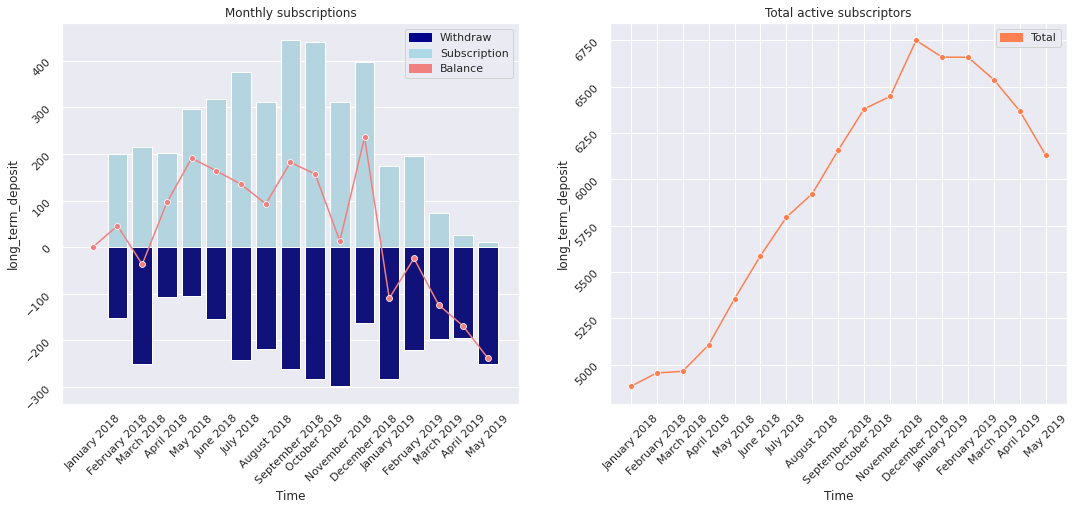

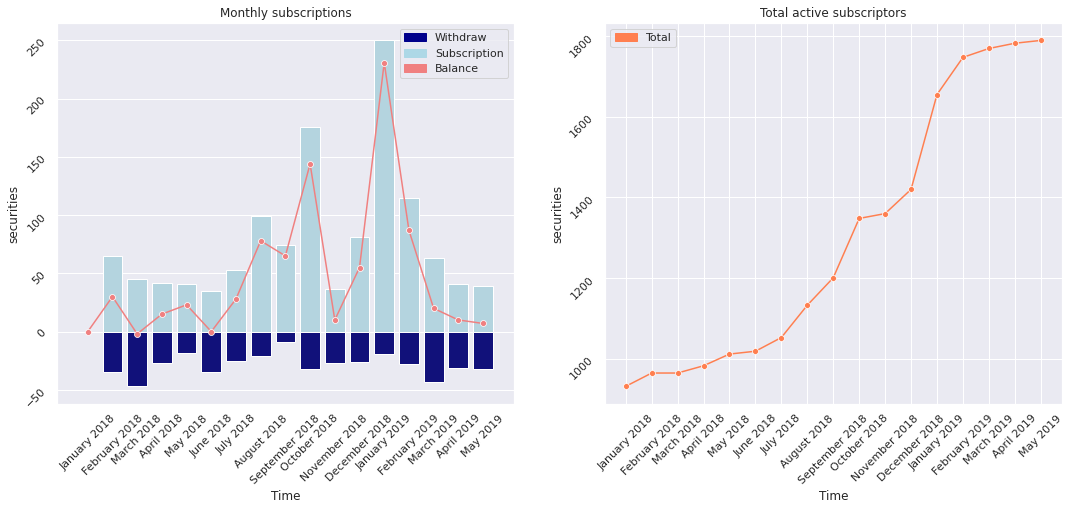

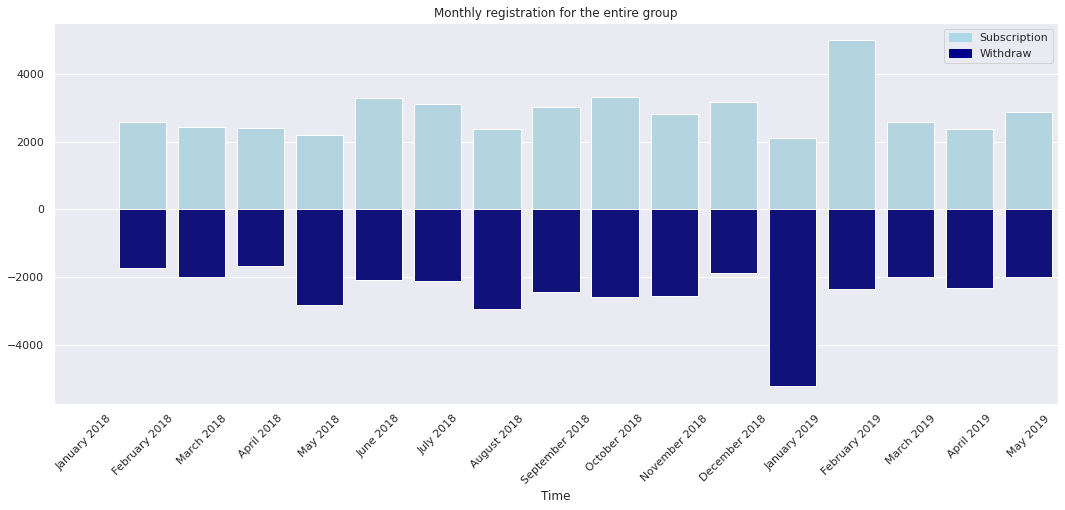

In [32]:
v_40 = ['funds', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'securities']

plot_class = Plots(df=alta_baja_df,products=v_40)

plot_class.alta_baja_plot()

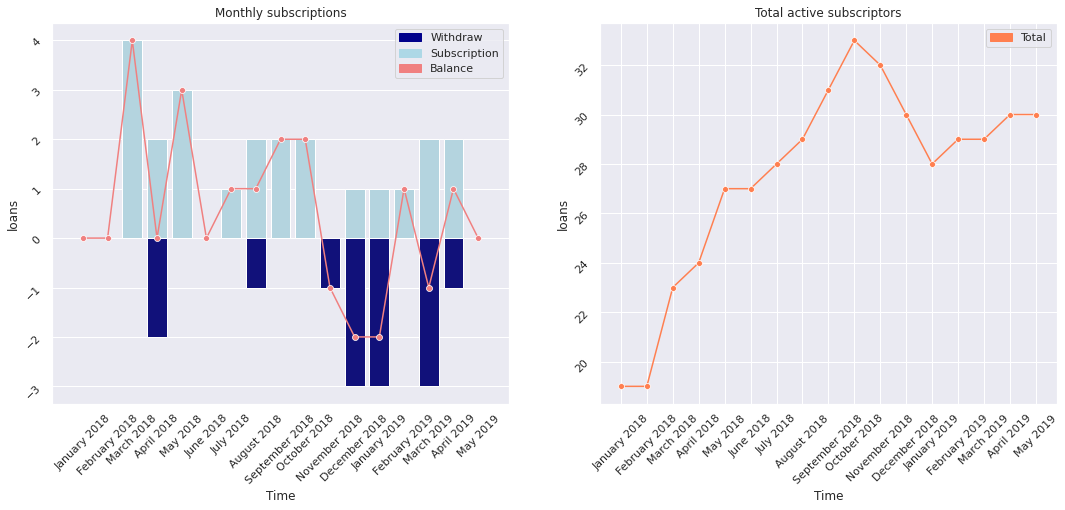

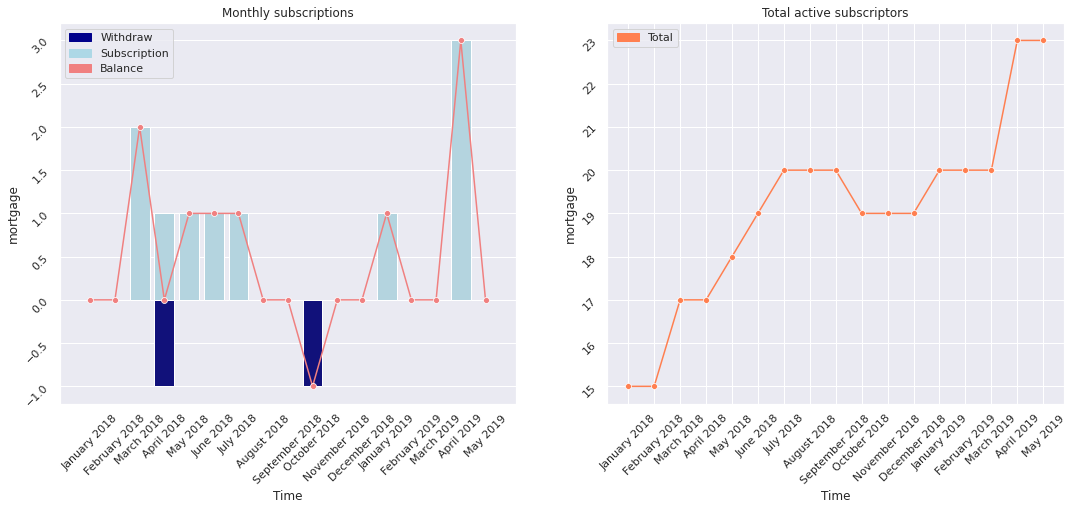

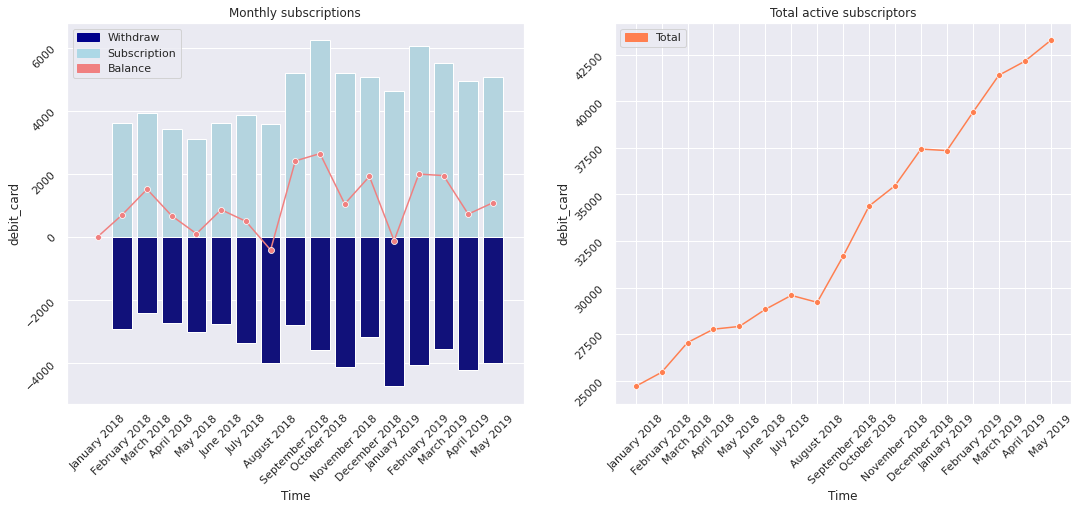

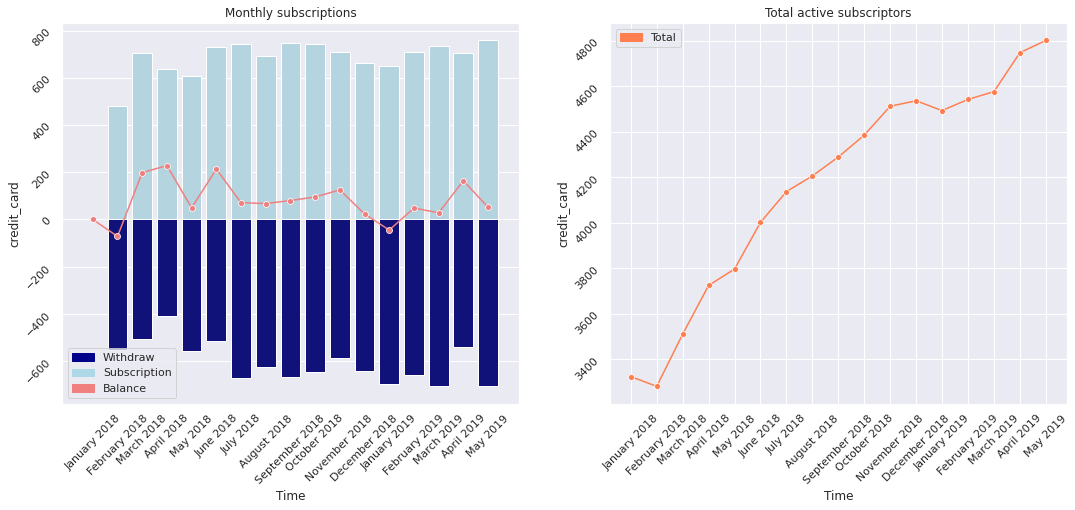

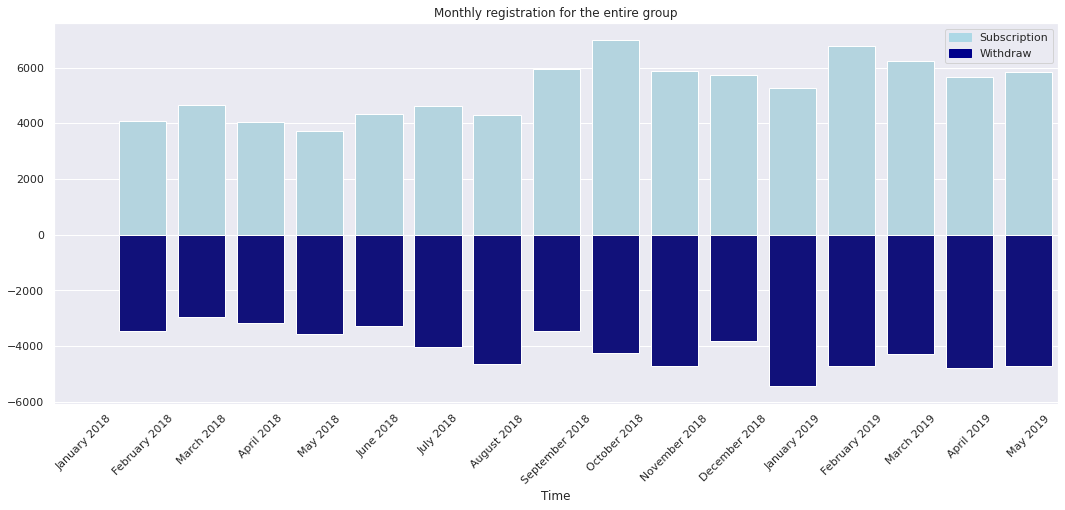

In [33]:
v_60 = ['loans', 'mortgage', 'debit_card', 'credit_card']

plot_class = Plots(df=alta_baja_df,products=v_60)

plot_class.alta_baja_plot()